# Use Crocoddyl to run the trajectory

The idea of this page is to take the trajectory given by maciej as an input (cost function) and see if crocoddyl can perform a feasable trajectory.

In [1]:
# import robot_loader from scripts and do basic configuration
import pinocchio as pin
import crocoddyl
import os
import numpy as np
from scripts.robot_loader import *
from scripts.trajectory_utils import convert_trajectory_to_pinocchio_format
import meshcat.geometry as mg

# load model on Meshcat
model, collision_model, visual_model, robot_visualizer, viz = launch_visualization()

print(f"--- Pinocchio model datas ---")
print(f"Robot name: {model.name}")
print(f"Configuration dimension (nq): {model.nq}")
print(f"Velocity dimension (nv): {model.nv}")

data = model.createData()
robot_visualizer.data = data

# Display some frames
frames_to_display = ["pelvis", "left_ground", "right_ground"]
frame_ids = [model.getFrameId(frame_name) for frame_name in frames_to_display]
robot_visualizer.displayFrames(True, frame_ids)

# Path to trajectory datas 
trajectory_file = os.path.join("data", "h1v2_squat_fixed_ankle_states.npy")
raw_trajectory = np.load(trajectory_file)

# call conversion tool
q_trajectory, v_trajectory = convert_trajectory_to_pinocchio_format(raw_trajectory)

# Display first trajectory data
q0 = q_trajectory[0]
robot_visualizer.display(q0)
pin.forwardKinematics(model, data, q0)
pin.updateFramePlacements(model, data)

# get ids for contacts
left_foot_id = model.getFrameId("left_ground")
right_foot_id = model.getFrameId("right_ground")
contact_frame_ids = [left_foot_id, right_foot_id]

--- Searching for robot paths ---
Detected project root directory: /home/cpene/Documents/robot_playground
Asset paths verified.
Detected urdf file: /home/cpene/Documents/robot_playground/robot_models/h1_2_description/h1_2_handless.urdf
Detected mesh directory: /home/cpene/Documents/robot_playground/robot_models/h1_2_description
Launching MeshCat...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Adding a grid to represent the ground.
Loading robot model into Pinocchio...
Pinocchio model loaded successfully.
Frame 'left_ground' added successfully.
Frame 'right_ground' added successfully.

Environment is ready !
--- Pinocchio model datas ---
Robot name: h1_2
Configuration dimension (nq): 34
Velocity dimension (nv): 33
raw trajectory dimension (raw_trajectory.shape): (176, 67)
q trajectory dimension (q_trajectory.shape): (176, 34)
v trajectory dimension (v_trajectory.shape): (176, 33)
Raw trajectory converted and separated into q and v trajectories

## Implement trajectory with crocoddyl

The aim is to provide a feasable trajectory with the input one.
I will try to add as less cost as possible. 
Costs added will be :
regulation control cost -> with trajectory input, customable weight
contact friction cone



In [2]:
from ocp.ocp_builder import OCPBuilder
from ocp.cost_manager import CostModelManager
from ocp.contact_manager import ContactModelManager

# trajectory inputs 
TRAJECTORY_STEP = len(q_trajectory) #176
TIME_STEP = 0.033
HORIZON_LENGTH = TRAJECTORY_STEP - 1

q0 = q_trajectory[0]
v0 = v_trajectory[0]
x0 = np.concatenate([q0, v0])

# initiate OCP
ocp_build = OCPBuilder(initial_state=x0,
                                 rmodel=model,
                                 dt=TIME_STEP,
                                 horizon_length=HORIZON_LENGTH)

# create contacts
running_contact_managers = []
for i in range (HORIZON_LENGTH):
    contact_manager_i = ContactModelManager(ocp_build.state, ocp_build.actuation, model, data)
    contact_manager_i.add_contact_6D("left_ground") \
                     .add_contact_6D("right_ground")
    running_contact_managers.append(contact_manager_i)

terminal_contact_manager = ContactModelManager(ocp_build.state, ocp_build.actuation, model, data) \
        .add_contact_6D("left_ground") \
        .add_contact_6D("right_ground")

# DEBUG
#terminal_contact_manager.display_contacts()

In [9]:
# create costs
running_cost_managers = []

#config_filepath = 'config/H1_squat_traj/regulation_state_weights.yaml'
config_filepath = 'config/H1_squat_traj/state_corridor.yaml'

for i in range (HORIZON_LENGTH):
    x_trajectory = np.concatenate([q_trajectory[i+1], v_trajectory[i+1]])
    cost_manager = CostModelManager(ocp_build.state, ocp_build.actuation)
    # add_weighted_regulation_state_cost(x_ref=x_trajectory, config_filepath=config_filepath, weight=1e-2)
    cost_manager.add_state_corridor_cost(x_ref=x_trajectory, config_filepath=config_filepath, weight=1.0, scale=1.0) \
                  .add_regulation_control_cost(1e-6) \
                  .add_contact_friction_cone_cost(contact_frame_ids, 0.7, 1e-6)
    
    running_cost_managers.append(cost_manager)
    
terminal_cost_manager = CostModelManager(ocp_build.state, ocp_build.actuation)
terminal_cost_manager.add_regulation_state_cost(x0, 1e-2) \
                     .add_contact_friction_cone_cost(contact_frame_ids, 0.7, 2e1)

# DEBUG
#terminal_cost_manager.display_costs()

# finalize OCP
problem = ocp_build.build(running_cost_managers, terminal_cost_manager, running_contact_managers, terminal_contact_manager)

print("OCP problem is ready")

OCP problem is ready


In [10]:
# Create FDDP solver
solver = crocoddyl.SolverFDDP(problem)

solver.setCallbacks([
    crocoddyl.CallbackLogger(),
    #crocoddyl.CallbackVerbose()
])

# Create an initial guess 
# we are looking at a problem with TRAJECTORY_STEP states and HORIZON_LENGTH commands
xs_init = []
for i in range(TRAJECTORY_STEP):
    x_trajectory = np.concatenate([q_trajectory[i], v_trajectory[i]])
    xs_init.append(x_trajectory)
print(f"xs_init dimension : {len(xs_init)}")

a0 = np.zeros(model.nv)
full_gravity_torques = pin.rnea(model, data, q0, v0, a0)
actuated_gravity_torques = full_gravity_torques[6:]

us_init = [actuated_gravity_torques] * HORIZON_LENGTH
print(f"us_init dimension : {len(us_init)}")


MAX_ITER = 2000  # max iteration
converged = solver.solve(xs_init, us_init, MAX_ITER)


# Results analysis
if converged:
    print("SUCCESS: FDDP converged.")
else:
    print("FAILURE: FDDP did not converge.")

xs_init dimension : 176
us_init dimension : 175
SUCCESS: FDDP converged.


In [197]:
# try mim_solver
import mim_solvers
import time
import math

solver = mim_solvers.SolverCSQP(problem)

solver.with_callbacks = True 
solver.termination_tolerance = 1e-3
solver.max_qp_iters = 1000
solver.eps_abs = 1e-5
solver.eps_rel = 0.
solver.use_filter_line_search = True

print("Solving OCP...")
start_time = time.time()
solver.solve(xs_init, us_init)
end_time = time.time()
print(f"Solver finished in {end_time - start_time:.2f} seconds.")


Solving OCP...
Solver finished in 19.79 seconds.


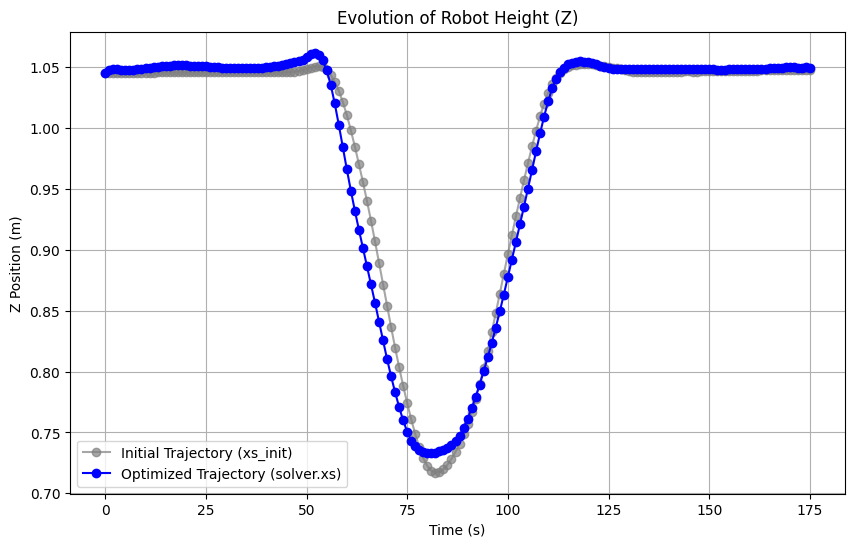

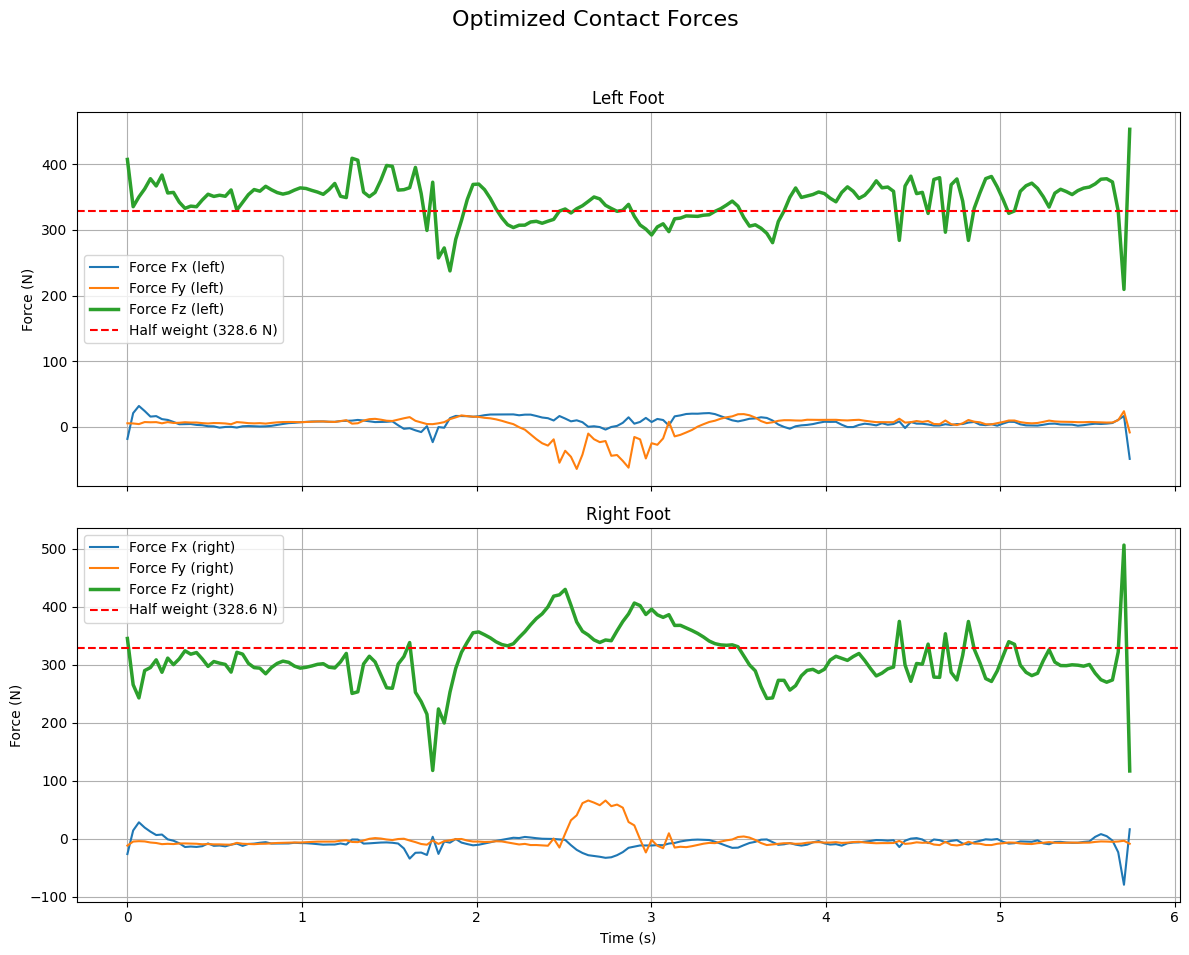

In [11]:
# PLOTS
import matplotlib.pyplot as plt
import numpy as np

# output from the solver
xs_res = solver.xs
us_res = solver.us

z_optimized = [x[2] for x in xs_res]
z_init = [x[2] for x in xs_init]
# Create the time axis for the plot
time_axis = [TIME_STEP for TIME_STEP in range(TRAJECTORY_STEP)]
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_axis, z_init, 'o-', label="Initial Trajectory (xs_init)", color='gray', alpha=0.7)
plt.plot(time_axis, z_optimized, 'o-', label="Optimized Trajectory (solver.xs)", color='blue')
plt.title("Evolution of Robot Height (Z)")
plt.xlabel("Time (s)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.grid(True)
plt.show()


# --- CONTACT FORCES EXTRACTION ---

# We retrieve data from each time step (except the terminal node)
running_datas = solver.problem.runningDatas

left_forces = []
right_forces = []

for datas in running_datas:

    contact_datas = datas.differential.multibody.contacts
    
    f_left = contact_datas.contacts['left_ground_contact'].f.vector
    f_right = contact_datas.contacts['right_ground_contact'].f.vector
    
    left_forces.append(f_left)
    right_forces.append(f_right)

left_forces = np.array(left_forces)
right_forces = np.array(right_forces)

time_axis_f = np.arange(len(left_forces)) * TIME_STEP


# --- DISPLAYING FORCES ---

# Creating a figure with two subplots (one for each foot)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Optimized Contact Forces', fontsize=16)

# Graph for the left foot
axs[0].plot(time_axis_f, left_forces[:, 0], label="Force Fx (left)")
axs[0].plot(time_axis_f, left_forces[:, 1], label="Force Fy (left)")
axs[0].plot(time_axis_f, left_forces[:, 2], label="Force Fz (left)", linewidth=2.5)
axs[0].set_title("Left Foot")
axs[0].set_ylabel("Force (N)")
axs[0].grid(True)

# Graph for the right foot
axs[1].plot(time_axis_f, right_forces[:, 0], label="Force Fx (right)")
axs[1].plot(time_axis_f, right_forces[:, 1], label="Force Fy (right)")
axs[1].plot(time_axis_f, right_forces[:, 2], label="Force Fz (right)", linewidth=2.5)
axs[1].set_title("Right Foot")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Force (N)")
axs[1].grid(True)

# Display total robot weight as a reference
try:
    robot_weight = pin.computeTotalMass(model) * 9.81
    axs[0].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Half weight ({robot_weight/2:.1f} N)')
    axs[1].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Half weight ({robot_weight/2:.1f} N)')
except NameError:
    print("Variable 'q0' is not defined, unable to display robot weight.")

axs[0].legend()
axs[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
# Launch the simulation
import time
print("Starting animation...")

TIME_STEP = 0.033

xs_opt = solver.xs
xs_opt_array = np.array(solver.xs)
traj = xs_opt_array[:, :model.nq]

for q in traj:

    # Send q to robot visualization
    robot_visualizer.display(q)

    # dt is TIME_STEP
    time.sleep(TIME_STEP)

print("\nAnimation end.")

Starting animation...

Animation end.


In [13]:
# Save output trajectory

from scripts.trajectory_utils import convert_pinocchio_to_trajectory_format

output_filename = 'data/crocoddyl_traj_11092025.npy'


v_trajectory = xs_opt_array[:, model.nq:]

x_opt_trajectory = convert_pinocchio_to_trajectory_format(q_trajectory, v_trajectory)

print(f"\nSaving the trajectory to '{output_filename}'...")
np.save(output_filename, x_opt_trajectory)

print(f"Trajectory successfully saved. Shape: {x_opt_trajectory.shape}")

q trajectory dimension (q_trajectory.shape): (176, 34)
v trajectory dimension (v_trajectory.shape): (176, 33)
Reconstituted raw trajectory dimension (raw_trajectory.shape): (176, 67)
Pinocchio q and v trajectories converted back to raw trajectory format.

Saving the trajectory to 'data/crocoddyl_traj_11092025.npy'...
Trajectory successfully saved. Shape: (176, 67)


In [200]:
print(f"{model.joints[1].shortname()}")

JointModelFreeFlyer
